[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/fig_A2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Arabas_et_al_2023/fig_A2ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/fig_A2.ipynb)

In [1]:
import os
import itertools
import numpy as np
from matplotlib import pyplot
import pickle

from PySDM import Builder, Formulae
from PySDM.dynamics import Freezing
from PySDM.environments import Box
from PySDM.physics import constants_defaults as const
from PySDM.physics import si
from PySDM.products import IceWaterContent
from PySDM.backends import GPU

from open_atmos_jupyter_utils import show_plot

In [2]:
CI = 'CI' in os.environ

RATE_MARGIN = .15
TIME_MARGIN = .25

N_SEEDS = 32 if not CI else 1

DTS = (5, 50, 500, 5000, 50000) if not CI else (50000,)

MLT = (1, 4, 16, 64, 256, 1024) if not CI else (4096,)
SEEDS = tuple(range(N_SEEDS)) if not CI else (44,)

RATE = 1e-7 / si.s

immersed_surface_area = 1

number_of_real_droplets = 256 * max(MLT)
total_time = (
    1e5  # effectively interpreted here as seconds, i.e. cycle = 1 * si.s
)

def error_norm(actual, expected):
    return np.sqrt(np.mean(np.square(actual - expected)))

In [ ]:
cases = tuple({"dt": dt, "N": mlt, "seed": seed} for dt, mlt, seed in itertools.product(DTS, MLT, SEEDS))

# dummy (but must-be-set) values
vol = 44  # for sign flip (ice water has negative volumes), value does not matter
d_v = 666  # products use conc., dividing there, multiplying here, value does not matter

output = {}

products = (IceWaterContent(name="qi"),)
backend_class = GPU

for double_precision in (True, False):
    backend_key = ('double' if double_precision else 'single') + ' precision'
    output[backend_key] = {}
    for case in cases:
        formulae = Formulae(
            particle_shape_and_density="MixedPhaseSpheres",
            heterogeneous_ice_nucleation_rate="Constant",
            constants={"J_HET": RATE / immersed_surface_area},
            seed=case['seed'],
        )
        
        n_sd = int(number_of_real_droplets // case["N"])
        assert n_sd == number_of_real_droplets / case["N"]
        assert total_time // case["dt"] == total_time / case["dt"]

        key = f"{case['dt']}:{n_sd}:{case['seed']}"
        print(key, "...")
        output[backend_key][key] = {"unfrozen_fraction": [], "dt": case["dt"], "N": case["N"]}

        builder = Builder(n_sd=n_sd, backend=backend_class(formulae=formulae, double_precision=double_precision))
        builder.set_environment(Box(dt=case["dt"], dv=d_v))
        builder.add_dynamic(Freezing(singular=False))
        attributes = {
            "multiplicity": np.full(n_sd, int(case["N"])),
            "immersed surface area": np.full(n_sd, immersed_surface_area),
            "volume": np.full(n_sd, vol),
        }
        particulator = builder.build(attributes=attributes, products=products)
        particulator.environment["RH"] = 1.0001
        particulator.environment["a_w_ice"] = np.nan
        particulator.environment["T"] = np.nan

        cell_id = 0
        for i in range(int(total_time / case["dt"]) + 1):
            particulator.run(0 if i == 0 else 1)

            ice_mass_per_volume = particulator.products["qi"].get()[cell_id]
            ice_mass = ice_mass_per_volume * d_v
            ice_number = ice_mass / (const.rho_w * vol)
            unfrozen_fraction = 1 - ice_number / number_of_real_droplets
            output[backend_key][key]["unfrozen_fraction"].append(unfrozen_fraction)
        
with open('output.pkl','wb') as file:
    pickle.dump(output, file)

In [ ]:
with open('output.pkl','rb') as file:
    output = pickle.load(file)

In [5]:
for backend_key in output.keys():
    for key, out in output[backend_key].items():
        dt_to_shortest_dt = out['dt'] / min(DTS)
        assert int(dt_to_shortest_dt) == dt_to_shortest_dt
        
        sim_y = np.asarray(out["unfrozen_fraction"])
        sim_x = out["dt"] * np.arange(sim_y.size)
        output[backend_key][key]['mse'] = error_norm(
            actual=sim_y[1:],
            expected=np.exp(-RATE * sim_x[1:])
        ) 
        
        sim_y = np.repeat(np.asarray(out["unfrozen_fraction"][1:]), dt_to_shortest_dt)
        sim_x = out["dt"] / dt_to_shortest_dt * np.arange(1, sim_y.size + 1)
        output[backend_key][key]['mse_interp'] = error_norm(
            actual=sim_y,
            expected=np.exp(-RATE * sim_x)
        ) 
        #assert abs(1 - output[backend_key][key]['mse_interp'] / output[backend_key][key]['mse']) < 1.5

In [6]:
def hgh(t):
    return np.exp(-(1 - RATE_MARGIN) * RATE * (t - total_time * TIME_MARGIN))

def low(t):
    return np.exp(-(1 + RATE_MARGIN) * RATE * (t + total_time * TIME_MARGIN))

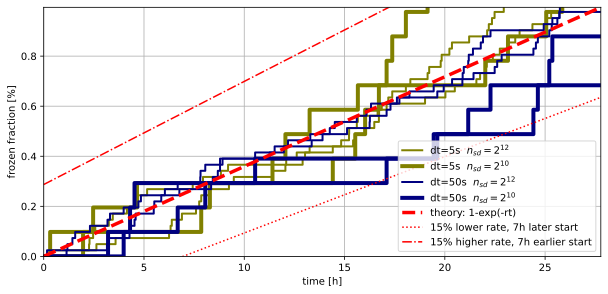

HTML(value="<a href='./fig_convergence_double precision.pdf' target='_blank'>./fig_convergence_double precisio…

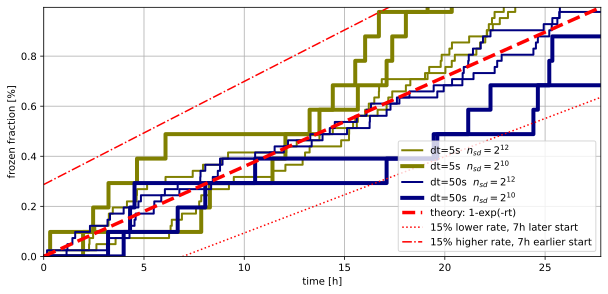

HTML(value="<a href='./fig_convergence_single precision.pdf' target='_blank'>./fig_convergence_single precisio…

In [7]:
for backend_key in output.keys():
    fig, ax = pyplot.subplots(1, 1, figsize=(10, 4.5))
    for key, out in output[backend_key].items():
        dt, n_sd, seed = key.split(':')
        fit_x = np.linspace(0, total_time, num=100)
        fit_y = np.exp(-RATE * fit_x)

        sim_x = out["dt"] * np.arange(len(out["unfrozen_fraction"]))
        sim_y = np.asarray(out["unfrozen_fraction"])
        if int(dt) in DTS[0:2] and number_of_real_droplets//int(n_sd) in MLT[3:5] and int(seed) in SEEDS[-2:]:
            ax.step(
                sim_x / 60 / 60,
                (1-sim_y) * 100,
                label=f"dt={out['dt']:g}s  $n_{{sd}}=2^{{{int(np.log2(int(n_sd)))}}}$" if int(seed) != SEEDS[-1] else "",
                color={DTS[0]: 'olive', DTS[1]: 'navy'}[int(dt)],
                linewidth=2 + out["N"] // 128,
            )
    ax.plot(
        fit_x / 60 / 60, (1-fit_y) * 100, color="red", linestyle="--", label="theory: 1-exp(-rt)", linewidth=3.5
    )
    ax.plot(
        fit_x / 60 / 60, (1-hgh(fit_x)) * 100, color="red", linestyle=":", label=f"{100*RATE_MARGIN:g}% lower rate, {total_time*TIME_MARGIN/60/60:.0g}h later start"
    )
    ax.plot(
        fit_x / 60 / 60, (1-low(fit_x)) * 100, color="red", linestyle="-.", label=f"{100*RATE_MARGIN:g}% higher rate, {total_time*TIME_MARGIN/60/60:.0g}h earlier start"
    )
    ax.legend(loc='lower right')
    ax.set_ylim(100 * (1-fit_y[0]), 100 * (1-fit_y[-1]))
    ax.set_xlim(0, total_time / 60 / 60)
    ax.set_xlabel("time [h]")
    ax.set_ylabel("frozen fraction [%]")
    ax.grid()
    show_plot(f"fig_convergence_{backend_key}.pdf")

In [8]:
NORM_TYPE = 'mse'

In [9]:
mean = {}
serr = {}
for backend_key in output.keys():
    mean[backend_key] = {}
    serr[backend_key] = {} 
    for n_real in range(1, len(SEEDS)+1):
        mean[backend_key][n_real] = np.zeros(shape=(len(DTS), len(MLT)))
        serr[backend_key][n_real] = np.zeros(shape=(len(DTS), len(MLT)))
        tmp = serr[backend_key][n_real]
        for key in output[backend_key].keys():
            dt, n_sd, seed = key.split(':')
            if int(seed) in SEEDS[0:n_real]:
                i = DTS.index(float(dt))
                j = MLT.index(number_of_real_droplets // int(n_sd))
                mse = output[backend_key][key][NORM_TYPE]
                mean[backend_key][n_real][i, j] += mse
                tmp[i, j] += mse**2
        mean[backend_key][n_real] /= n_real
        tmp /= n_real
        tmp -= mean[backend_key][n_real]**2
        mask = tmp > 0
        serr[backend_key][n_real][mask] = np.sqrt(tmp[mask] / n_real)
        serr[backend_key][n_real][~mask] = 0

5
50
500
5000


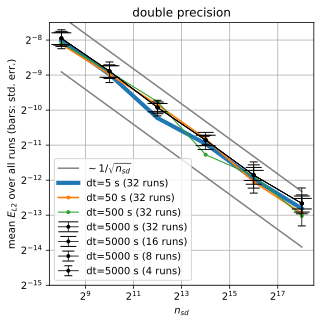

HTML(value="<a href='./fig_lines_double precision.pdf' target='_blank'>./fig_lines_double precision.pdf</a><br…

5
50
500
5000


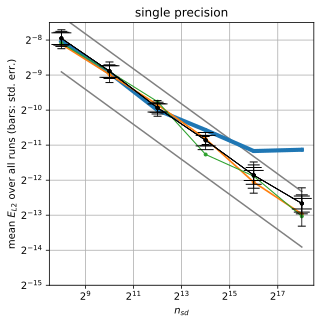

HTML(value="<a href='./fig_lines_single precision.pdf' target='_blank'>./fig_lines_single precision.pdf</a><br…

In [12]:
FIGSIZE = (4.75, 4.75)

for backend_key in output.keys():
    fig, ax = pyplot.subplots(1, 1, figsize=FIGSIZE)
    pick_n_real = len(SEEDS)
    pick_dt = -2
    
    x = number_of_real_droplets // np.asarray(MLT)
    for i, c in enumerate((.0333, .0999)):
        ax.plot(x, c * x**-.5, color='gray', label=r'$\sim 1/\sqrt{n_{sd}}$' if i==0 else '')

    for i, dt in enumerate(DTS):
        if dt > 5000:
            continue
        print(dt)
        x = number_of_real_droplets // np.asarray(MLT)
        y = mean[backend_key][pick_n_real][i, :]
        common_kwargs = {'marker': '.', 'linewidth': 6.66/np.log(float(dt))}
        label = f"dt={dt:d} s"
        if dt == DTS[pick_dt]:
            for n_real in reversed(range(1, len(SEEDS)+1)):
                if n_real < 4 or np.log2(n_real) != int(np.log2(n_real)):
                    continue
                ax.errorbar(x=x, y=y,
                    yerr=serr[backend_key][n_real][i, :],
                    capsize=2*np.log2(n_real),
                    **common_kwargs,
                    color='black',
                    label=label + f" ({n_real} runs)"
                )
        else:
            ax.plot(x, y, **common_kwargs, label=label + f" ({pick_n_real} runs)")
            
    pyplot.xscale('log', base=2)
    pyplot.yscale('log', base=2)
    if backend_key == 'double precision':
        pyplot.legend(loc="lower left")
    pyplot.xlabel("$n_{sd}$")
    pyplot.ylabel(r'mean $E_{L2}$ over all runs (bars: std. err.)')
    pyplot.grid()
    pyplot.title(backend_key + (' (interpolated MSE)' if NORM_TYPE == 'mse_interp' else ''))
    pyplot.ylim(2**-15, 2**-7.5)
    show_plot(f'fig_lines_{backend_key}.pdf')